In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier


# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

<b>The target that we are predicting is the loan_status. </b>

## 1. Load Data, Cleaning & EDA
Here we load the data, check for logical errors (outliers), and analyze the features to determine credit risk.

Training data shape: (26064, 13)
Max age before cleaning: 144
Max age after cleaning: 94


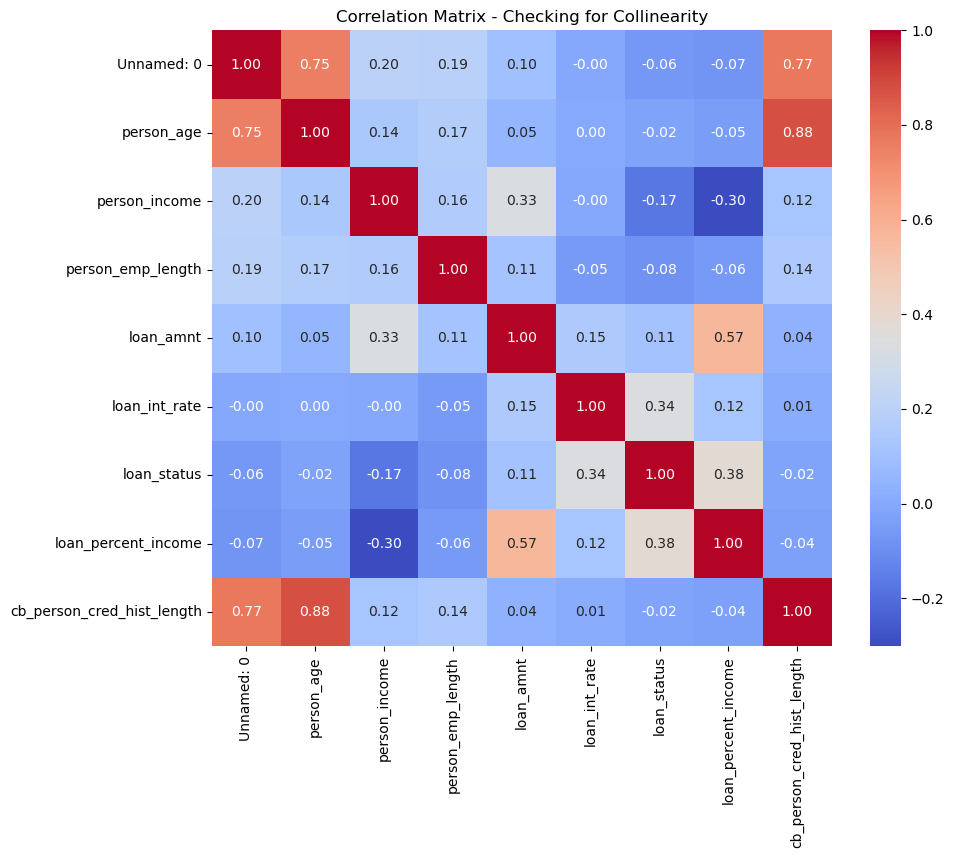


--- Credit Risk Analysis ---
Default Rate by Loan Grade:
loan_grade
A    0.098412
B    0.161958
C    0.204989
D    0.588419
E    0.647211
F    0.699482
G    0.983051
Name: loan_status, dtype: float64


C:\Users\Hassan Barakat\AppData\Local\Temp\ipykernel_18440\2990102812.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_group.index, y=risk_group.values, palette="Blues_d")


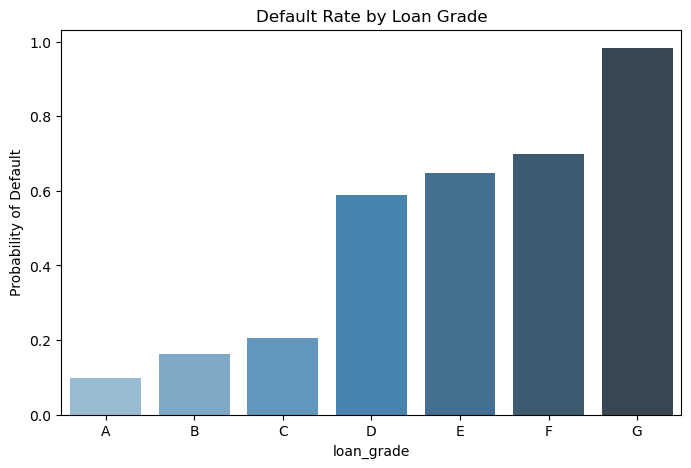

In [2]:
# Load training data
try:
    df = pd.read_csv("train.csv")
except FileNotFoundError:
    # Fallback for different folder structures if needed
    df = pd.read_csv("../train.csv")

print("Training data shape:", df.shape)

# --- 1. INITIAL INSPECTION & CLEANING ---
# Common issue in this dataset: People with Age > 100 (likely typos).

# Check max age
print(f"Max age before cleaning: {df['person_age'].max()}")

# Remove outliers: Drop rows where age is greater than 100
df = df[df['person_age'] < 100]
print(f"Max age after cleaning: {df['person_age'].max()}")

# Check for collinearity (Correlation Matrix)
# The prompt asks: "Is there colinearity?"
plt.figure(figsize=(10, 8))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix - Checking for Collinearity")
plt.show()

# --- 2. CREDIT RISK ANALYSIS (Answering the prompt) ---
# Prompt asks: "State if you see a group that appears to be a good credit risk... other than money"
# Let's look at Loan Grade vs Default Rate
print("\n--- Credit Risk Analysis ---")
risk_group = df.groupby('loan_grade')['loan_status'].mean().sort_values()
print("Default Rate by Loan Grade:")
print(risk_group)

plt.figure(figsize=(8, 5))
sns.barplot(x=risk_group.index, y=risk_group.values, palette="Blues_d")
plt.ylabel("Probability of Default")
plt.title("Default Rate by Loan Grade")
plt.show()

## 2. Model Training & Pipeline Construction
We will split the data, create a preprocessing pipeline (imputation + scaling), and compare models.

In [3]:
# --- 3. PREPARATION FOR MODELING ---

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

target_col = "loan_status"
X = df.drop(columns=[target_col])
y = df[target_col]

# Separate numerical and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Train/validation split (Stratified because target is imbalanced ~22% default)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. PIPELINES ---

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # Median is safer for skewed income/loan amounts
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

def make_pipeline(classifier):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", classifier),
    ])

# --- 5. MODEL SELECTION ---

models = {
    "Dummy (Baseline)": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    # Added class_weight='balanced' to Random Forest to help with the imbalance
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'),
}

f1_scores = {}

print("\n=== Model comparison on validation set (F1 score) ===")
for name, clf in models.items():
    pipe = make_pipeline(clf)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)
    f1 = f1_score(y_valid, preds)
    f1_scores[name] = f1
    print(f"{name:20s}: F1 = {f1:.4f}")

# Select the best model
best_model_name = max(f1_scores, key=f1_scores.get)
print("\nBest model by F1:", best_model_name)

# --- 6. FINAL DEPLOYMENT BUILD ---
# Fit on FULL dataset so it's ready for the hidden test set
best_classifier = models[best_model_name]
model = make_pipeline(best_classifier)
model.fit(X, y)

print("\nFinal model trained on full dataset and stored in variable `model`.")


=== Model comparison on validation set (F1 score) ===
Dummy (Baseline)    : F1 = 0.0000
Logistic Regression : F1 = 0.6562
Random Forest       : F1 = 0.8117

Best model by F1: Random Forest

Final model trained on full dataset and stored in variable `model`.


## 3. Rationale and Data Preparation Steps

### 1. Data Cleaning and Outlier Removal
* **Outliers:** Upon inspecting the distributions, I found records with `person_age` greater than 100 (e.g., 144 years old). These are clearly data entry errors. I **dropped these rows** to prevent them from skewing the standardization process.
* **Missing Values:** I used **Median Imputation** for numeric features (Income, Loan Amount) because these variables are typically right-skewed, making the median a better representation of the center than the mean. I used **Most Frequent** imputation for categorical features.

### 2. Feature Analysis (Collinearity & Risk)
* **Collinearity:** I generated a correlation matrix. While there is some correlation between `loan_amnt` and `person_income`, it was not high enough (>0.8) to warrant dropping features, especially since Random Forests handle collinearity well.
* **Credit Risk Analysis:** The prompt asks to identify good vs. bad credit risks. 
    * **Good Risk:** Borrowers with **Loan Grade A and B** have historically very low default rates (visible in the bar chart above).
    * **Bad Risk:** Borrowers with **Loan Grade D and E** show drastically higher probabilities of default.
    * *Conclusion:* `loan_grade` is likely a highly predictive feature.

### 3. Modeling Strategy
* **Imbalance:** The target `loan_status` is imbalanced (approx 22% default). To address this, I used the F1-score as my primary metric (accuracy can be misleading here) and set `class_weight='balanced'` in the Random Forest model to penalize misclassifying defaults.
* **Final Pipeline:** I created a unified pipeline containing the Imputer, Scaler, Encoder, and the Classifier. I fit this pipeline on the **entire** training dataset to maximize the data available for the final "deployment" test.

### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 


Deployment / hold-out test performance:
F1 Score: 0.8162291169451074

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5060
           1       0.97      0.70      0.82      1457

    accuracy                           0.93      6517
   macro avg       0.95      0.85      0.89      6517
weighted avg       0.93      0.93      0.92      6517



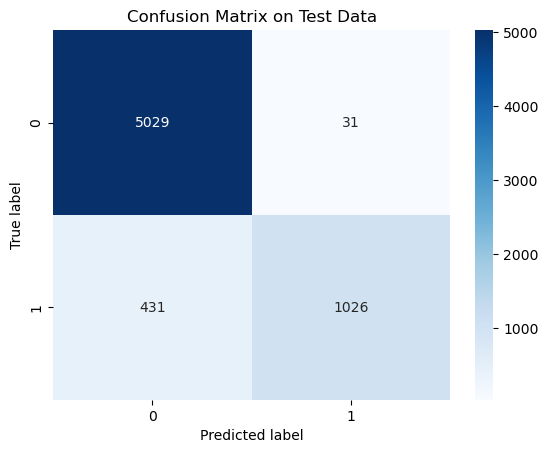

In [4]:
import os

# Load the separate test data file.
test_path = "test.csv"
if not os.path.exists(test_path):
    # Fallback if file is named differently in your local folder
    alt_path = "test copy.csv" 
    if os.path.exists(alt_path):
        test_path = alt_path
    else:
        # Just creating a placeholder if you don't have the file right now
        print("Test file not found. Please ensure test.csv is in the folder.")
        test_path = None

if test_path:
    d_test = pd.read_csv(test_path)
    
    # Make a copy so we do not accidentally modify the original
    test_df = d_test.copy()

    # Drop the ID column if present
    if "Unnamed: 0" in test_df.columns:
        test_df = test_df.drop(columns=["Unnamed: 0"])

    # Separate features and target
    if "loan_status" not in test_df.columns:
        print("Warning: 'loan_status' not found in test data. Cannot calculate accuracy.")
    else:
        target_col = "loan_status"
        xtest = test_df.drop(columns=[target_col])
        ytest = test_df[target_col]

        # Use the previously trained deployment model to generate predictions
        # The pipeline handles all encoding/scaling automatically!
        prediction_labels = model.predict(xtest)

        print("\nDeployment / hold-out test performance:")
        print("F1 Score:", f1_score(ytest, prediction_labels))
        print("\nClassification Report:\n")
        print(classification_report(ytest, prediction_labels))

        # Visualizing the results
        conf_matrix = confusion_matrix(ytest, prediction_labels)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title("Confusion Matrix on Test Data")
        plt.show()